In [2]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def generate_contingency_tables(vals):
    tables = np.zeros(shape=(vals.size**4,4));
    i = 0;
    for tp in vals:
        for tn in vals:
            for fp in vals:
                for fn in vals:
                    tables[i] = [tp,tn,fp,fn];
                    i += 1;
    return tables;

In [4]:
# takes mxn
def return_ranks(scores_array):
    temp = np.argsort(scores_array)[::-1];

    ranks_array = np.empty(len(scores_array), float);
#   Assigning ranks to the scores according to the order in 'temp' array (descending score)
    ranks_array[temp] = np.arange(len(scores_array));
#   Assigning nan ranks to nan scores
    ranks_array[np.isnan(scores_array)] = np.nan;

    unique, counts = np.unique(scores_array[~np.isnan(scores_array)], return_counts=True);
#     print(unique)

# Handle ties by assigning averaged values to the tied scores
    for idx,u in enumerate(unique):
        ranks_array[scores_array==u] = ranks_array[scores_array==u].sum()/counts[idx];
    return ranks_array

In [4]:
def recall (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f01;
    if den == 0:
        return np.nan;
    else:
        return num/den;
    
def precision (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f10;
    if den == 0:
        return np.nan;
    else:
        return num/den;
confidence = precision;

def mutual_information(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if f11 != 0 and f00 != 0 and f01 != 0 and f10 != 0:
        MI = f11 * np.log2((f11 * N)/((f11 + f10)*(f11 + f01)))
        + f10 * np.log2((f10 * N)/((f11 + f10)*(f10 + f00))) 
        + f01 * np.log2((f01 * N)/((f01 + f00)*(f11 + f01)))
        + f00 * np.log2((f00 * N)/((f01 + f00)*(f10 + f00)));
        return MI/N;
    else:
        return np.nan;

def jaccard (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if (f11 + f10 + f01) == 0:
        return np.nan;
    else:
        J = f11 / (f11 + f10 + f01);
        return J;

def f_measure (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;

    if f11 == 0:
        return np.nan;
    else:
    #     P_(a given b)
        P_agb = f11 / (f11 + f01);
    #     P_(b given a)
        P_bga = f11 / (f11 + f10);

        FM = (2*P_agb*P_bga) / (P_agb + P_bga);
        return FM;
    
def odds_ratio(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    OR = (f11 * f00)/(f01 * f10);
    return OR;

def specificity(contingency_table):
    f11 = contingency_table[0];
#     f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    den = f00 + f01;
    if den != 0:
        return f00/den;
    else:
        return np.nan;
negative_reliability = specificity;

def sebag_schoenauer(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    if f10:
        return f11/f10;
    else:
        return np.nan;
def accuracy(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if N:
        return (f11 + f00)/N;
    else:
        return np.nan;
    
def support(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return f11/N;

def confidence_causal(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    CC = (f11/(f11+f10)) + (f00/(f00+f10));
    return CC/2;

def lift(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 * N)/((f11 + f10) * (f11 + f01));

def ganascia(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
#     f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    G = (f11 - f10) / (f11 + f10);
    return G;

def kulczynsky_1 (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    K = f11 / (f10 + f01);
    return K;

def coverage(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 + f10)/N;

def prevalence(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 + f01)/N;

def relative_risk(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    RR = (f11 * (f01 + f00)) / (f01 * (f11 + f10));
    return RR;

def piatetsky_shapiro(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_ab = f11/N;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    return P_ab - P_a*P_b;
novelty = piatetsky_shapiro;

def yules_q(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    YQ = (f11*f00 - f10*f01)/(f11*f00 + f10*f01);
    return YQ;

def yules_y(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    YY = (np.sqrt(f11*f00) - np.sqrt(f10*f01))/(np.sqrt(f11*f00) + np.sqrt(f10*f01));
    return YY;

def cosine(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    cosine = f11 / np.sqrt((f11 + f01)*(f11 + f10));
    return cosine;

def least_contradiction(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    LC = (f11 - f10) / (f11 + f01);
    return LC;

def odd_multiplier(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    OM = (f11 * (f00 + f10))/(f10 * (f11 + f01));
    return OM;

def confirm_descriptive(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CD = (f11 - f10)/N;
    return CD;

def confirm_causal(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CC = (f11 + f00 - 2*f10)/N;
    return CC;

def certainty_factor(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CF = 1 - (f10 * N)/((f11 + f10)*(f00 + f10));
    return CF;
loevinger = certainty_factor;

def conviction(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    conviction = ((f11 + f10)*(f00 + f10))/(f10 * N);
    return conviction;

def information_gain(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    
    IG = np.log2(f11/((f11 + f10)*(f11 + f01)));
    return IG;

def laplace_correction(contingency_table):
    k = 2;
    f11 = contingency_table[0];
    f10 = contingency_table[1];
#     f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    LC = (f11 + 1) / (f11 + f10 + k);
    return LC;

def klosgen(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    KL = np.sqrt(P_a) * ((f11/(f11 + f10)) - P_b);
    return KL;

def zhang(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    P_ab = f11/N;
    den_1 = P_ab * (1 - P_b);
    den_2 = P_b * (P_a - P_ab);
    if den_1 > den_2:
        ZH = (P_ab - P_a * P_b)/den_1;
    else:
        ZH = (P_ab - P_a * P_b)/den_2;
    return ZH;

def normalized_mutual_information(contingency_table):
    MI = mutual_information(contingency_table);
    Pa = P_a(contingency_table)
    NMI = MI / (-Pa * np.log2(Pa) - (1 - Pa) * np.log2(1 - Pa));
    return NMI;

def one_way_support(contingency_table):
    P_bgivena = P_b_given_a(contingency_table);
    Pb = P_b(contingency_table);
    OWS = P_bgivena * np.log2(P_bgivena / Pb);
    return OWS

def two_way_support(contingency_table):
    P_bgivena = P_b_given_a(contingency_table);
    Pb = P_b(contingency_table);
    Pab = P_ab(contingency_table);
    TWS = Pab * np.log2(P_bgivena / Pb);
    return TWS;

def implication_index(contingency_table):
    Pa = P_a(contingency_table);
    Pb = P_b(contingency_table);
    N = sum(contingency_table);
    f10 = contingency_table[1];
    
    prod = (Pa * (1-Pb)); 
    IIN = np.sqrt(N) * ((f10 / N) - prod) / np.sqrt(prod);
    return IIN;

def kappa(contingency_table):
    

In [5]:
def P_a (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_a = (f11+f10)/N;
    return P_a;

def P_b (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_b = (f11+f10)/N;
    return P_b;

def P_ab (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_ab = (f11)/N;
    return P_ab;

def P_a_given_b (contingency_table):
    f11 = contingency_table[0];
    f01 = contingency_table[2];
    P_a_given_b = f11 / (f11 + f01);
    return P_a_given_b;

def P_b_given_a (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    P_b_given_a = f11 / (f11 + f10);
    return P_b_given_a;

In [5]:
def compute_scores(scores, contingency_tables):
# idxt - index of a contingency table
    for idxt,table in enumerate(contingency_tables):
        scores[idxt,0] = recall(table);
        scores[idxt,1] = precision(table);
        scores[idxt,2] = confidence(table);
        scores[idxt,3] = mutual_information(table);
        scores[idxt,4] = jaccard(table);
        scores[idxt,5] = f_measure(table);
        scores[idxt,6] = odds_ratio(table);
        scores[idxt,7] = specificity(table);
        scores[idxt,8] = negative_reliability(table);
        scores[idxt,9] = sebag_schoenauer(table);
        scores[idxt,10] = accuracy(table);
        scores[idxt,11] = support(table);
        scores[idxt,12] = confidence_causal(table);
        scores[idxt,13] = lift(table);
        scores[idxt,14] = ganascia(table);
        scores[idxt,15] = kulczynsky_1(table);
        scores[idxt,16] = coverage(table);
        scores[idxt,17] = prevalence(table);
        scores[idxt,18] = relative_risk(table);
        scores[idxt,19] = piatetsky_shapiro(table);
        scores[idxt,20] = novelty(table);
        scores[idxt,21] = yules_q(table);
        scores[idxt,22] = yules_y(table);
        scores[idxt,23] = cosine(table);
        scores[idxt,24] = least_contradiction(table);
        scores[idxt,25] = odd_multiplier(table);
        scores[idxt,26] = confirm_descriptive(table);
        scores[idxt,27] = confirm_causal(table);
        scores[idxt,28] = certainty_factor(table);
        scores[idxt,29] = loevinger(table);
        scores[idxt,30] = conviction(table);
        scores[idxt,31] = information_gain(table);
        scores[idxt,32] = laplace_correction(table);
        scores[idxt,33] = klosgen(table);
        scores[idxt,34] = zhang(table);
        scores[idxt,35] = normalized_mutual_information(table);
        scores[idxt,36] = one_way_support(table);
        scores[idxt,37] = two_way_support(table);
        scores[idxt,38] = implication_index(table);

    return scores;

In [5]:
def compute_ranks(ranks, scores):
    for idx,score in enumerate(scores.T):
    #     print(score)
        ranks[:,idx] = return_ranks(score);
    return ranks;

In [6]:
def show_correlation_matrix(ranks_matrix):
#     ranks_matrix - mxn matrix where m are observations
    dist_spearman = spearmanr(ranks_matrix);
    plt.figure(figsize=(10,10));
    sns.heatmap(dist_spearman.correlation, vmin=0, vmax=1, cmap='YlGnBu');
    plt.show()

def show_dendrogram(ranks_matrix):
#     ranks_matrix - mxn matrix where m are observations
    Y = pdist(ranks_matrix.T, 'correlation');
    Z = hierarchy.linkage(squareform(Y), method='complete');
    plt.figure(figsize=(10,10));
    hierarchy.dendrogram(Z, orientation='right', color_threshold=1)
    plt.show()

In [35]:
vals = np.array([1,2,11,100,1000,10000]);
tables = generate_contingency_tables(vals);

scores_matrix = np.zeros(shape=(1296,39));
scores_matrix = compute_scores(scores_matrix, tables);

ranks = np.zeros(shape = scores_matrix.shape)
ranks = compute_ranks(ranks, scores_matrix);

# show_correlation_matrix(ranks);
# show_dendrogram(ranks);

In [166]:
properties_df = pd.read_csv('measures_properties.csv')

In [34]:
# properties_df.head()

In [92]:
properties_df = properties_df.drop('No', axis=1);

In [93]:
properties_df['O1'] = properties_df['O1'].map({'Y':1, 'N':0});

In [94]:
properties_df['O2'] = properties_df['O2'].map({'Y':1, 'N':0});

In [95]:
properties_df['O3'] = properties_df['O3'].map({'Y':1, 'N':0});
properties_df['O3\''] = properties_df['O3\''].map({'Y':1, 'N':0});
properties_df['O4'] = properties_df['O4'].map({'Y':1, 'N':0});

In [96]:
properties_df['P1'] = properties_df['P1'].map({'Y':1, 'N':0});
properties_df['P2'] = properties_df['P2'].map({'Y':1, 'N':0});
properties_df['P3'] = properties_df['P3'].map({'Y':1, 'N':0});

In [100]:
properties_df['UNAI'] = properties_df['UNAI'].map({'Y': 1, 'N': 0});
properties_df['UNZR'] = properties_df['UNZR'].map({'Strong': 2, 'Weak': 1, 'Nothing': 0});


In [33]:
# p_df = properties_df[['UNZR','UNAI','P1', 'P2','P3','O1', 'O2', 'O3', 'O3\'', 'O4']];

In [31]:
# show_rank_correlation_matrix(p_df)
# show_ranks_dendrogram(p_df)

In [32]:
# properties_df.head()

In [189]:
properties_contingency_table = pd.crosstab([properties_df.P1, properties_df.P2, properties_df.P3,
             properties_df.O1,properties_df.O2,properties_df.O3,
            properties_df['O3\''],properties_df.O4],
            [properties_df.UNAI],
            rownames=['P1', 'P2', 'P3','O1', 'O2', 'O3', 'O3\'', 'O4'],
            colnames=['UNAI'], margins=True);

In [24]:
# properties_contingency_table

array([    1.,    11.,  1000.,  1000.])

In [10]:
class contingency_table(object):
    def __init__(self, table = np.array([]), n_measures = 0):
        self.table = table;
        self.scores = np.zeros(n_measures);
#         self.ranks = np.zeros();
        
    def compute_probabilities(self):
        self.f11 = self.table[0];
        self.f10 = self.table[1];
        self.f01 = self.table[2];
        self.f00 = self.table[3];
        self.N = sum(self.table);
        
        self.P_a = (self.f11 + self.f10)/self.N;
        self.P_b = (self.f11 + self.f01)/self.N;
        self.P_aprime = 1 - self.P_a;
        self.P_bprime = 1 - self.P_b;

        
        self.P_ab = self.f11/self.N;
        self.P_abprime = self.f10/self.N;
        self.P_aprimeb = self.f01/self.N;
        self.P_aprimebprime = self.f00/self.N;

        self.P_agivenb = self.P_ab / self.P_b;
        self.P_bgivena = self.P_ab / self.P_a;
        self.P_bgivenaprime = self.P_aprimeb / self.P_aprime;
    
    def compute_scores(self):
        self.compute_probabilities();
        self.scores[0] = self.recall();
        self.scores[1] = self.precision();
        self.scores[2] = self.confidence();
        self.scores[3] = self.mutual_information();
        self.scores[4] = self.jaccard();
        self.scores[5] = self.f_measure();
        self.scores[6] = self.odds_ratio();
        self.scores[7] = self.specificity();
        self.scores[8] = self.negative_reliability();
        self.scores[9] = self.sebag_schoenauer();
        self.scores[10] = self.accuracy();
        self.scores[11] = self.support();
        self.scores[12] = self.confidence_causal();
        self.scores[13] = self.lift();
        self.scores[14] = self.ganascia();
        self.scores[15] = self.kulczynsky_1();
        self.scores[16] = self.coverage();
        self.scores[17] = self.prevalence();
        self.scores[18] = self.relative_risk();
        self.scores[19] = self.piatetsky_shapiro();
        self.scores[20] = self.novelty();
        self.scores[21] = self.yules_q();
        self.scores[22] = self.yules_y();
        self.scores[23] = self.cosine();
        self.scores[24] = self.least_contradiction();
        self.scores[25] = self.odd_multiplier();
        self.scores[26] = self.confirm_descriptive();
        self.scores[27] = self.confirm_causal();
        self.scores[28] = self.certainty_factor();
        self.scores[29] = self.loevinger();
        self.scores[30] = self.conviction();
        self.scores[31] = self.information_gain();
        self.scores[32] = self.laplace_correction();
        self.scores[33] = self.klosgen();
        self.scores[34] = self.zhang();
        self.scores[35] = self.normalized_mutual_information();
        self.scores[36] = self.one_way_support();
        self.scores[37] = self.two_way_support();
        self.scores[38] = self.implication_index();
    
    def recall (self):
        if (self.f11 + self.f01) == 0:
            return np.nan
        else:
            return self.f11 / (self.f11 + self.f01);

    def precision (self):
        if (self.f11 + self.f10) == 0:
            return np.nan;
        else:
            return self.f11/(self.f11 + self.f10);
    
    def confidence (self):
        return self.precision();
    
    def mutual_information(self):
        if self.f11 != 0 and self.f00 != 0 and self.f01 != 0 and self.f10 != 0:
            MI = self.P_ab * np.log2(self.P_ab/(self.P_a * self.P_b))
            + self.P_abprime * np.log2(self.P_abprime/(self.P_a * self.P_bprime))
            + self.P_aprimeb * np.log2(self.P_aprimeb/(self.P_aprime * self.P_b))
            + self.P_aprimebprime * np.log2(self.P_aprimebprime/(self.P_aprime * self.P_bprime));        
            return MI/self.N;
        else:
            return np.nan;

    def jaccard (self):
        if (self.f11 + self.f10 + self.f01) == 0:
            return np.nan;
        else:
            J = self.f11 / (self.f11 + self.f10 + self.f01);
            return J;

    def f_measure (self):
        if self.P_agivenb + self.P_bgivena == 0:
            return np.nan;
        else:
            FM = (2 * self.P_agivenb * self.P_bgivena) / (self.P_agivenb + self.P_bgivena);
            return FM;
    
    def odds_ratio(self):
        OR = (self.f11 * self.f00)/(self.f01 * self.f10);
        return OR;

    def specificity(self):
        den = self.f00 + self.f01;
        if den != 0:
            return self.f00/den;
        else:
            return np.nan;
    
    def negative_reliability(self):
        return self.specificity();

    def sebag_schoenauer(self):
        if self.f10:
            return self.f11/self.f10;
        else:
            return np.nan;
        
    def accuracy(self):
        if self.N:
            return (self.f11 + self.f00)/self.N;
        else:
            return np.nan;

    def support(self):
        return self.f11/self.N;

    def confidence_causal(self):
        CC = (self.f11 / (self.f11 + self.f10)) + (self.f00 / (self.f00 + self.f10));
        return CC/2;

    def lift(self):
        return (self.f11 * self.N)/((self.f11 + self.f10) * (self.f11 + self.f01));

    def ganascia(self):
        G = 2 * self.P_bgivena - 1;
        return G;

    def kulczynsky_1 (self):
        K = self.f11 / (self.f10 + self.f01);
        return K;

    def coverage(self):
        return self.P_a;

    def prevalence(self):
        return self.P_b;

    def relative_risk(self):
        RR = self.P_bgivena / self.P_bgivenaprime;
        return RR;

    def piatetsky_shapiro(self):
        return self.P_ab - self.P_a * self.P_b;

    def novelty(self):
        return self.piatetsky_shapiro();

    def yules_q(self):
        YQ = (self.f11 * self.f00 - self.f10 * self.f01) / (self.f11 * self.f00 + self.f10 * self.f01);
        return YQ;

    def yules_y(self):
        YY = (np.sqrt(self.f11 * self.f00) - np.sqrt(self.f10 * self.f01)) / (np.sqrt(self.f11 * self.f00) + np.sqrt(self.f10 * self.f01));
        return YY;

    def cosine(self):
        cosine = self.P_ab / np.sqrt(self.P_a * self.P_b);
        return cosine;

    def least_contradiction(self):
        LC = (self.f11 - self.f10) / (self.f11 + self.f01);
        return LC;

    def odd_multiplier(self):
        OM = (self.P_ab * self.P_bprime) / (self.P_b * self.P_abprime);
        return OM;

    def confirm_descriptive(self):
        CD = self.P_ab - self.P_abprime;
        return CD;

    def confirm_causal(self):
        CC = self.P_ab + self.P_aprimeb - 2 * self.P_abprime;
        return CC;

    def certainty_factor(self):
        CF = 1 - self.P_abprime / (self.P_a * self.P_bprime)
        return CF;
    
    def loevinger(self):
        return self.certainty_factor();

    def conviction(self):
        conviction = (self.P_a * self.P_bprime) / self.P_abprime;
        return conviction;

    def information_gain(self):
        IG = np.log2(self.P_ab / (self.P_a * self.P_b));
        return IG;

    def laplace_correction(self):
        k = 2;
        LC = (self.f11 + 1) / (self.f11 + self.f10 + k);
        return LC;

    def klosgen(self):
        KL = np.sqrt(self.P_a) * (self.P_bgivena - self.P_b);
        return KL;

    def zhang(self):
        den_1 = self.P_ab * (1 - self.P_b);
        den_2 = self.P_b * (self.P_a - self.P_ab);
        if den_1 > den_2:
            ZH = (self.P_ab - self.P_a * self.P_b)/den_1;
        else:
            ZH = (self.P_ab - self.P_a * self.P_b)/den_2;
        return ZH;

    def normalized_mutual_information(self):
        MI = self.mutual_information();
        NMI = MI / (-self.P_a * np.log2(self.P_a) - self.P_aprime * np.log2(self.P_aprime));
        return NMI;

    def one_way_support(self):
        OWS = self.P_bgivena * np.log2(self.P_bgivena / self.P_b);
        return OWS

    def two_way_support(self):
        TWS = self.P_ab * np.log2(self.P_bgivena / self.P_b);
        return TWS;

    def implication_index(self):
        prod = self.P_a * self.P_bprime; 
        IIN = np.sqrt(N) * (self.P_abprime - prod) / np.sqrt(prod);
        return IIN;

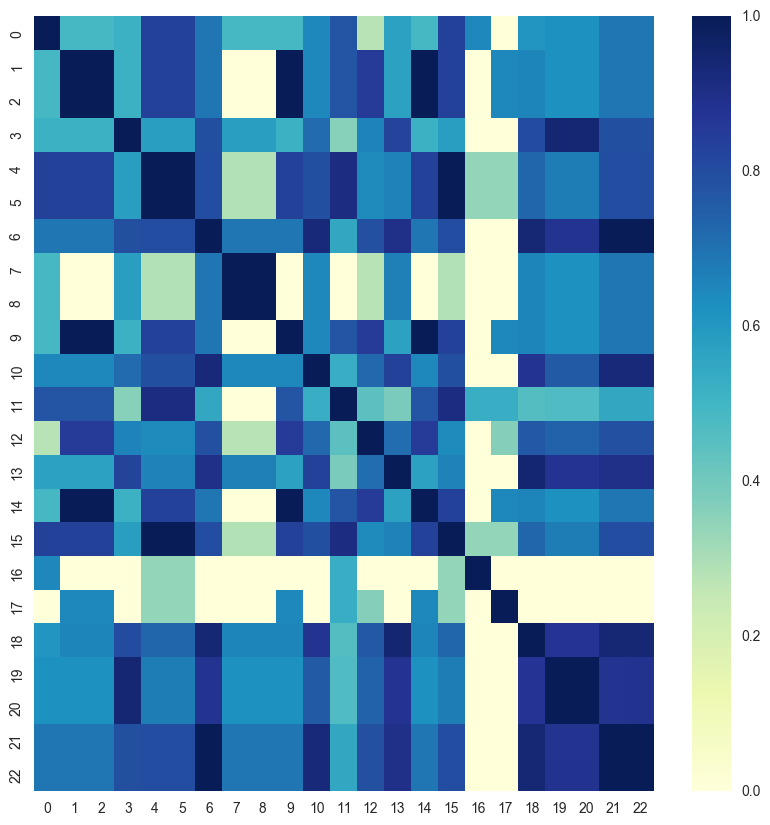

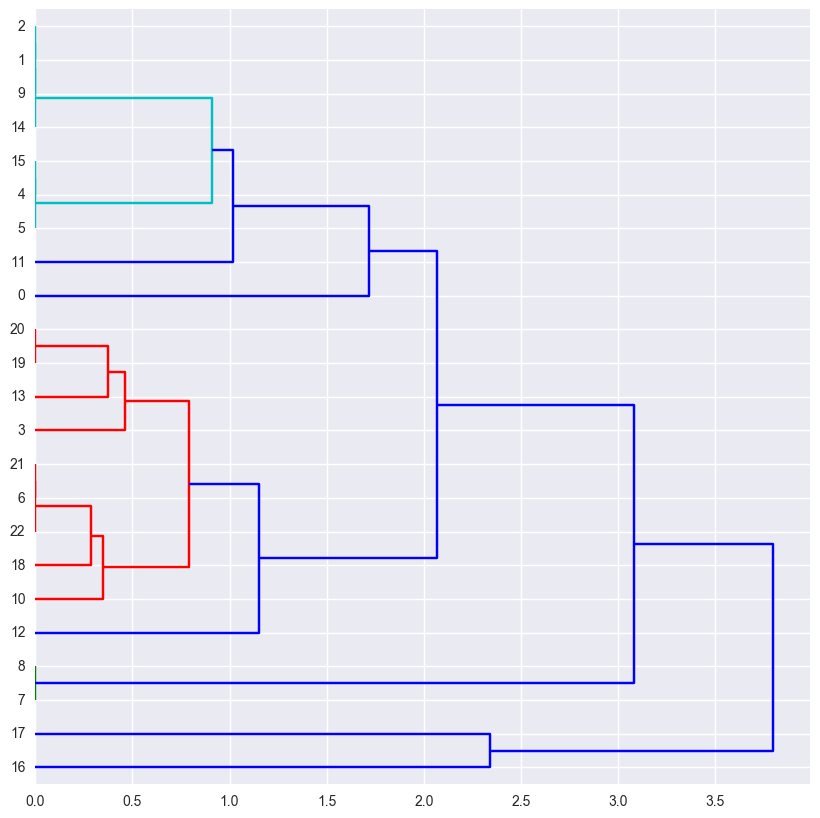

In [8]:
vals = np.array([1,2,11,100,1000,10000]);
tables = generate_contingency_tables(vals);
n_measures = 39;
scores_matrix = np.zeros(shape=(1296,n_measures));

for idx,table in enumerate(tables):
    t = contingency_table(table, n_measures);
    t.compute_scores();
    scores_matrix[idx] = t.scores;
    
ranks = np.zeros(shape = scores_matrix.shape)
ranks = compute_ranks(ranks, scores_matrix);

show_correlation_matrix(ranks);
show_dendrogram(ranks);